In [1]:
import os
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


root_path = Path(os.getcwd()).parent.resolve()
silver_path = str(root_path / 'data' / 'silver' / 'clean_impressions.parquet').replace('\\', '/')

conn = duckdb.connect()

## 1. Data Summary and Temporal Coverage

In [13]:
# Basic dataset stats
overview = conn.execute(f"""
    SELECT 
        COUNT(*) as total_impressions,
        COUNT(DISTINCT uid) as unique_users,
        COUNT(DISTINCT campaign) as unique_campaigns,
        MIN(timestamp) as min_timestamp,
        MAX(timestamp) as max_timestamp,
        (MAX(timestamp) - MIN(timestamp)) / 86400.0 as duration_days,
        MAX(day_number) as max_day_number,
        SUM(CAST(click AS INTEGER)) as total_clicks,
        SUM(CAST(conversion AS INTEGER)) as total_conversions,
        SUM(CAST(attribution AS INTEGER)) as attributed_conversions,
        COUNT(DISTINCT conversion_id) as unique_conversion_ids
    FROM read_parquet('{silver_path}')
""").df()

print("Dataset Overview:")
print(f"Total Impressions: {overview['total_impressions'].iloc[0]:,}")
print(f"Unique Users: {overview['unique_users'].iloc[0]:,}")
print(f"Unique Campaigns: {overview['unique_campaigns'].iloc[0]:,}")
print(f"Duration: {overview['duration_days'].iloc[0]:.1f} days")
print(f"Total Clicks: {overview['total_clicks'].iloc[0]:,}")
print(f"Total Conversions: {overview['total_conversions'].iloc[0]:,}")
print(f"Attributed Conversions: {overview['attributed_conversions'].iloc[0]:,}")
print(f"Unique Conversion ID: {overview['unique_conversion_ids'].iloc[0]:,}")

Dataset Overview:
Total Impressions: 16,468,027
Unique Users: 6,142,256
Unique Campaigns: 675
Duration: 30.9 days
Total Clicks: 5,947,563.0
Total Conversions: 806,196.0
Attributed Conversions: 442,424.0
Unique Conversion ID: 435,810


No gaps in temporal coverage


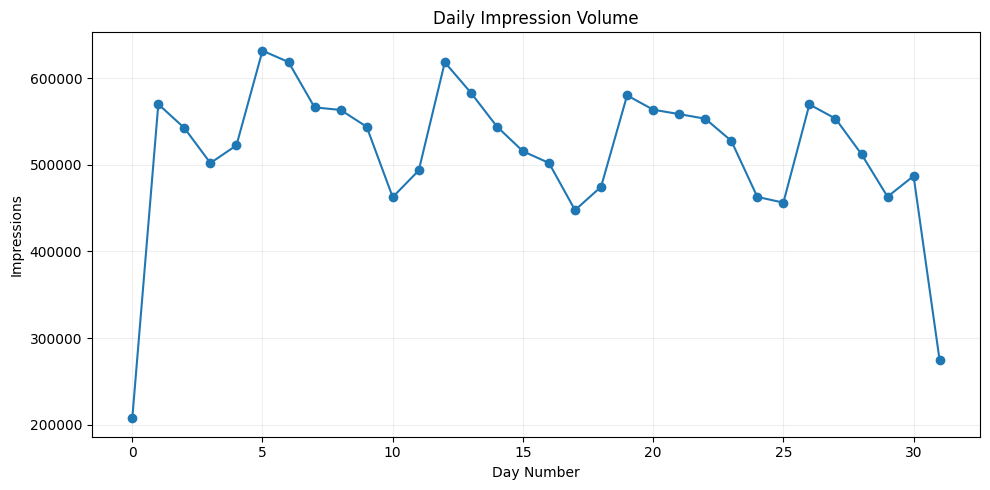

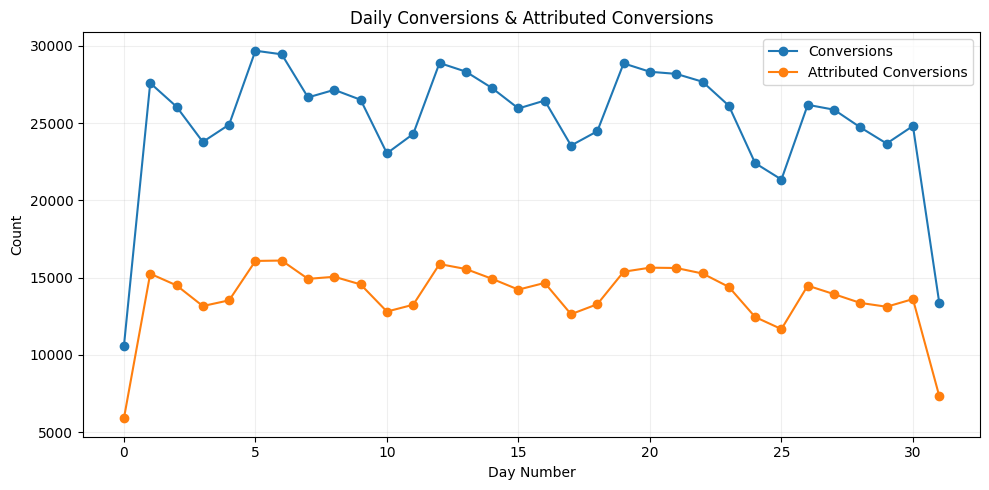

In [12]:
# Temporal Coverage
# Check for missing days
day_coverage = conn.execute(f"""
    WITH max_day AS (
        SELECT MAX(day_number)::INTEGER AS max_d FROM read_parquet('{silver_path}')
    ),
    day_series AS (
        SELECT unnest(generate_series(0, (SELECT max_d FROM max_day))) AS day_num
    ),
    actual_days AS (
        SELECT DISTINCT CAST(day_number AS INTEGER) as day_number
        FROM read_parquet('{silver_path}')
    )
    SELECT 
        ds.day_num,
        CASE WHEN ad.day_number IS NULL THEN 1 ELSE 0 END as is_missing
    FROM day_series ds
    LEFT JOIN actual_days ad ON ds.day_num = ad.day_number
    WHERE is_missing = 1
""").df()

if len(day_coverage) > 0:
    print(f"WARNING: {len(day_coverage)} days with missing data")
    print(day_coverage.head(10))
else:
    print("No gaps in temporal coverage")

# Daily impression volume
daily_volume = conn.execute(f"""
    SELECT 
        day_number,
        COUNT(*) as impressions,
        SUM(CAST(conversion AS INTEGER)) as conversions,
        SUM(CAST(attribution AS INTEGER)) as attributed_conversions
    FROM read_parquet('{silver_path}')
    GROUP BY day_number
    ORDER BY day_number
""").df()


# Plot 1: Day numbers vs Impressions
plt.figure(figsize=(10, 5))
plt.plot(daily_volume["day_number"], daily_volume["impressions"], marker='o')
plt.title("Daily Impression Volume")
plt.xlabel("Day Number")
plt.ylabel("Impressions")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Plot 2: Day numbers vs Conversions and Attributed Conversions
plt.figure(figsize=(10, 5))
plt.plot(daily_volume["day_number"], daily_volume["conversions"], marker='o', label='Conversions')
plt.plot(daily_volume["day_number"], daily_volume["attributed_conversions"], marker='o', label='Attributed Conversions')
plt.title("Daily Conversions & Attributed Conversions")
plt.xlabel("Day Number")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## Insights

1. **Conversion and Attribution rates**:
   1. ~0.8M total conversions; ~16.4 total impressions -> Implies that about ~5% of all the impressions led to a conversion. Hence, the conversion rate based on impressions would be ~5%.
   2. ~0.8M total conversions; ~0.44M attributed conversions -> Implies that about ~55% of conversions are attributed to Criteo. This tells us that Criteo's attribution model attributes roughly half of its conversions.
   3. ~0.44M attributed conversions; ~0.43M unique conversions -> This suggests that some users have more than one conversion.
2. **Complete temporal coverage**: No gaps in data across all the day numbers 0-31.

# 2. Campaign Performance Analysis
- Which campaigns have the highest conversion and attribution rates?
- What are the Cost distributions and Cost efficiencies across campaigns? 
  - Efficiency measured by **Cost Per Acquisition (CPA)**
    - $CPA = \frac{\text{Total Cost}}{\text{Num Attributions}}$
- Time based analysis: How do conversions vary by hour/day?

In [26]:
# Top Campaigns Performance Analysis
campaign_performance = conn.execute(f"""
    SELECT 
        campaign,
        COUNT(*) as impressions,
        SUM(CAST(click AS INTEGER)) as clicks,
        SUM(CAST(conversion AS INTEGER)) as conversions,
        SUM(CAST(attribution AS INTEGER)) as attributed_conversions,
        SUM(cost) as total_cost,
        AVG(cost_per_order_predicted) as avg_cost_per_order,
        -- Rates
        SUM(CAST(click AS INTEGER)) * 100.0 / COUNT(*) as click_through_rate,
        SUM(CAST(conversion AS INTEGER)) * 100.0 / COUNT(*) as conversion_rate,
        SUM(CAST(attribution AS INTEGER)) * 100.0 / NULLIF(SUM(CAST(conversion AS INTEGER)), 0) as attribution_rate,
        -- Efficiency
        SUM(cost) / NULLIF(SUM(CAST(attribution AS INTEGER)), 0) as cost_per_acquisition
    FROM read_parquet('{silver_path}')
    GROUP BY campaign
    HAVING impressions > 1000  -- Filter for statistical significance
    ORDER BY attributed_conversions DESC
    LIMIT 40
""").df()

print("\n=== Top 10 Campaigns by Attributed Conversions ===")
campaign_performance.head(10)


=== Top 10 Campaigns by Attributed Conversions ===


,campaign,impressions,clicks,conversions,attributed_conversions,total_cost,avg_cost_per_order,click_through_rate,conversion_rate,attribution_rate,cost_per_acquisition
0,10341182,437385,194847.0,45479.0,25702.0,139.162455,0.122751,44.548167,10.397933,56.513995,0.005414
1,32368244,161056,77584.0,36638.0,21946.0,138.096421,0.028125,48.172064,22.748609,59.899558,0.006293
2,15184511,256102,93175.0,36995.0,18936.0,153.826559,0.058807,36.381988,14.445416,51.185295,0.008123
3,9100693,100926,39442.0,23011.0,15820.0,20.840788,0.005145,39.080118,22.799873,68.749728,0.001317
4,15398570,378464,135066.0,23853.0,10176.0,155.572414,0.191634,35.687939,6.302581,42.661300,0.015288
5,30801593,431587,168971.0,20618.0,9531.0,25.596305,0.051233,39.151087,4.777252,46.226598,0.002686
6,2869134,55796,20032.0,11919.0,9499.0,3.441929,0.004000,35.902215,21.361746,79.696283,0.000362
7,16184517,56866,14747.0,9734.0,9160.0,8.138200,0.004189,25.932895,17.117434,94.103144,0.000888
8,9100689,52153,21023.0,8877.0,8130.0,17.621726,0.010675,40.310241,17.021073,91.584995,0.002167
9,18975823,217646,100798.0,10575.0,7669.0,82.155326,0.162222,46.312820,4.858807,72.520095,0.010713


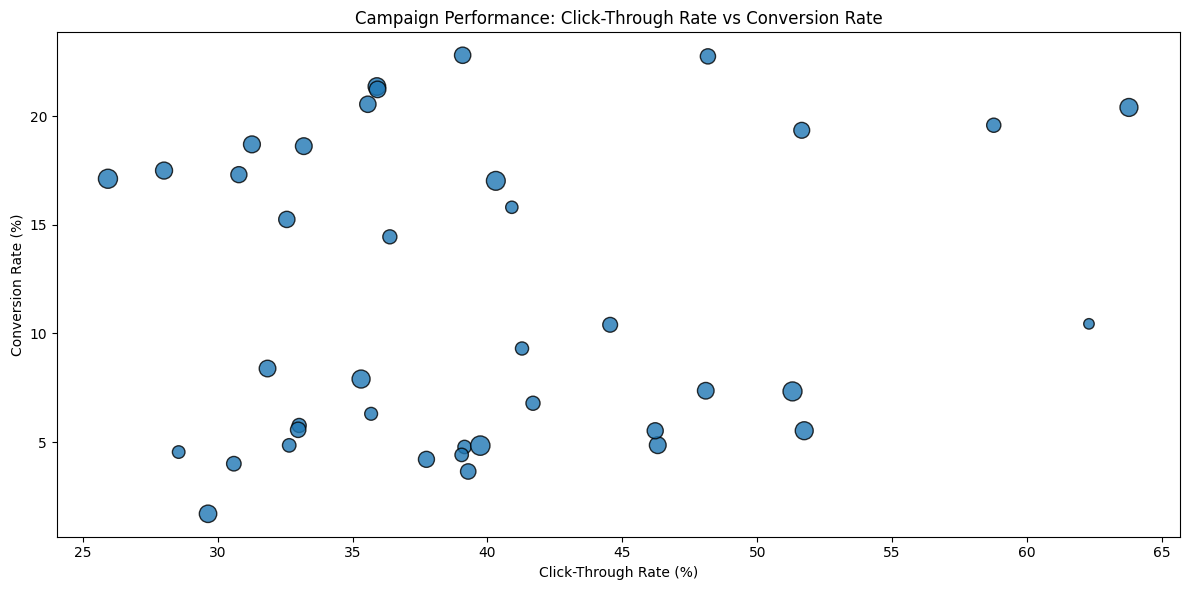

In [ ]:
# Visualize top campaigns 
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    campaign_performance['click_through_rate'],
    campaign_performance['conversion_rate'],
    # s=campaign_performance['attributed_conversions'] / campaign_performance['conversions'] * 200,
    alpha=0.8,
    edgecolor='k'
)

plt.xlabel('Click-Through Rate (%)')
plt.ylabel('Conversion Rate (%)')
plt.title('Campaign Performance: Click-Through Rate vs Conversion Rate')

plt.tight_layout()
plt.show()

In [37]:
# Cost Efficiency Analysis
cost_efficiency = conn.execute(f"""
    SELECT 
        campaign,
        COUNT(*) as impressions,
        SUM(CAST(attribution AS INTEGER)) as attributed_conversions,
        SUM(cost) as total_cost,
        SUM(cost) / NULLIF(SUM(CAST(attribution AS INTEGER)), 0) as cost_per_acquisition,
        AVG(cost_per_order_predicted) as avg_cost_per_order,
        AVG(cost) as avg_impression_cost,
        -- Compare predicted vs actual
        AVG(cost_per_order_predicted) - (SUM(cost) / NULLIF(SUM(CAST(attribution AS INTEGER)), 0)) as cpo_cpa_diff
    FROM read_parquet('{silver_path}')
    GROUP BY campaign
    HAVING attributed_conversions >= 10  -- At least 10 conversions
    ORDER BY cost_per_acquisition ASC
    LIMIT 30
""").df()

print("\n=== Most Cost-Efficient Campaigns (Lowest CPA) ===")
cost_efficiency.head(15)


=== Most Cost-Efficient Campaigns (Lowest CPA) ===


,campaign,impressions,attributed_conversions,total_cost,cost_per_acquisition,avg_cost_per_order,avg_impression_cost,cpo_cpa_diff
0,2869134,55796,9499.0,3.441929,0.000362,0.004000,0.000062,0.003638
1,3073305,8282,1096.0,0.421066,0.000384,0.004000,0.000051,0.003616
2,3073303,3429,448.0,0.173583,0.000387,0.004000,0.000051,0.003613
3,29531983,13563,1241.0,0.560173,0.000451,0.004000,0.000041,0.003549
4,2073319,3090,313.0,0.142800,0.000456,0.004000,0.000046,0.003544
5,29531976,1487,247.0,0.113727,0.000460,0.004052,0.000076,0.003591
6,3073302,8614,697.0,0.353643,0.000507,0.004000,0.000041,0.003493
7,15506599,6408,981.0,0.562000,0.000573,0.004075,0.000088,0.003502
8,30487330,2802,119.0,0.084622,0.000711,0.005865,0.000030,0.005154
9,24843272,14579,1689.0,1.208131,0.000715,0.005181,0.000083,0.004466


In [38]:
print("\n=== Least Cost-Efficient Campaigns (Highest CPA) ===")
cost_efficiency.tail(15)


=== Least Cost-Efficient Campaigns (Highest CPA) ===


,campaign,impressions,attributed_conversions,total_cost,cost_per_acquisition,avg_cost_per_order,avg_impression_cost,cpo_cpa_diff
15,29531977,1134,127.0,0.131605,0.001036,0.004610,0.000116,0.003573
16,5544859,50808,6388.0,6.640216,0.001039,0.004004,0.000131,0.002965
17,9100692,40265,6036.0,6.672559,0.001105,0.004477,0.000166,0.003372
18,29531970,7531,1184.0,1.318008,0.001113,0.005252,0.000175,0.004139
19,9610626,39029,2335.0,2.745001,0.001176,0.069181,0.000070,0.068005
20,73328,12950,849.0,1.001138,0.001179,0.007084,0.000077,0.005905
21,9100693,100926,15820.0,20.840788,0.001317,0.005145,0.000206,0.003828
22,73325,5692,285.0,0.425295,0.001492,0.007783,0.000075,0.006291
23,2073328,14469,960.0,1.460454,0.001521,0.010357,0.000101,0.008836
24,9100691,42272,4398.0,7.103155,0.001615,0.006957,0.000168,0.005342


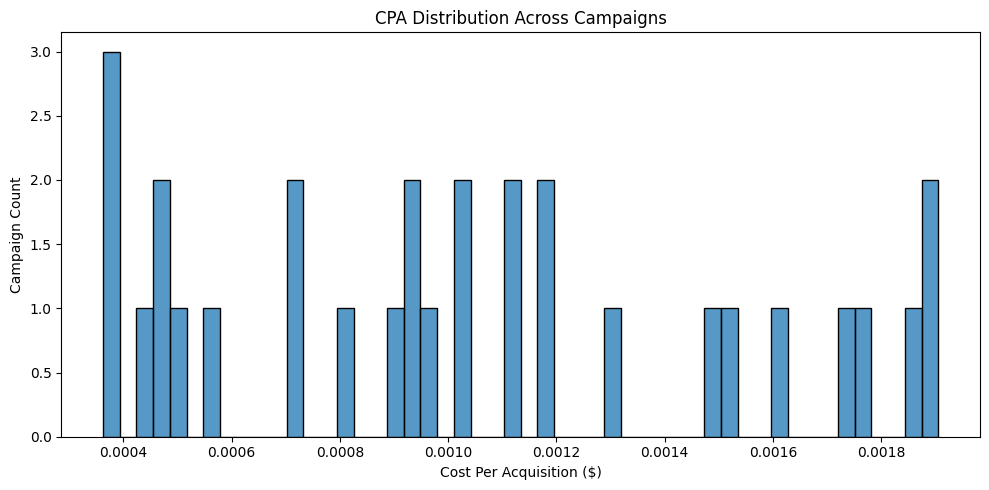

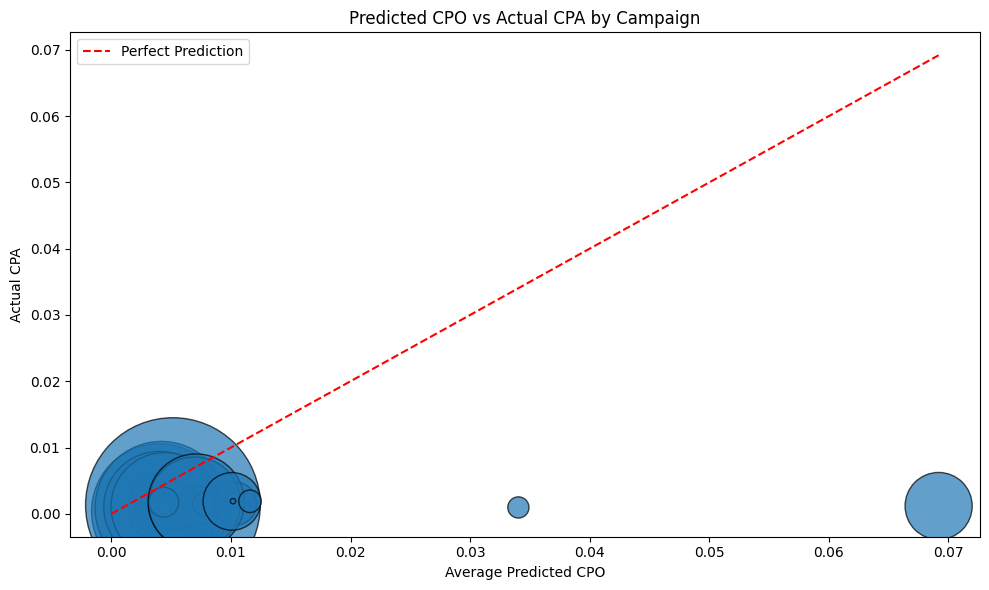

In [39]:

# CPA distribution 
plt.figure(figsize=(10, 5))
sns.histplot(cost_efficiency['cost_per_acquisition'], bins=50, kde=False)
plt.title('CPA Distribution Across Campaigns')
plt.xlabel('Cost Per Acquisition ($)')
plt.ylabel('Campaign Count')
plt.tight_layout()
plt.show()

# Predicted CPO vs Actual CPA scatter 
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    cost_efficiency['avg_cost_per_order'],
    cost_efficiency['cost_per_acquisition'],
    s=cost_efficiency['attributed_conversions'],  # bubble size
    alpha=0.7,
    edgecolor='k'
)
# Plot the diagonal (perfect prediction)
max_val = max(cost_efficiency['avg_cost_per_order'].max(), cost_efficiency['cost_per_acquisition'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')

plt.title('Predicted CPO vs Actual CPA by Campaign')
plt.xlabel('Average Predicted CPO')
plt.ylabel('Actual CPA')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Hourly performance
hourly_performance = conn.execute(f"""
    SELECT 
        hour_of_day,
        time_period,
        SUM(CAST(conversion AS INTEGER)) * 100.0 / COUNT(*) as cvr,
    FROM read_parquet('{silver_path}')
    GROUP BY hour_of_day, time_period
    ORDER BY hour_of_day
""").df()

print("\n=== Performance by Hour of Day ===")
hourly_performance


=== Performance by Hour of Day ===


,hour_of_day,time_period,cvr
0,0,night,4.962663
1,1,night,4.971694
2,2,night,5.018304
3,3,night,5.078359
4,4,night,5.164093
5,5,night,5.290315
6,6,morning,5.290489
7,7,morning,5.354096
8,8,morning,5.267819
9,9,morning,5.223965


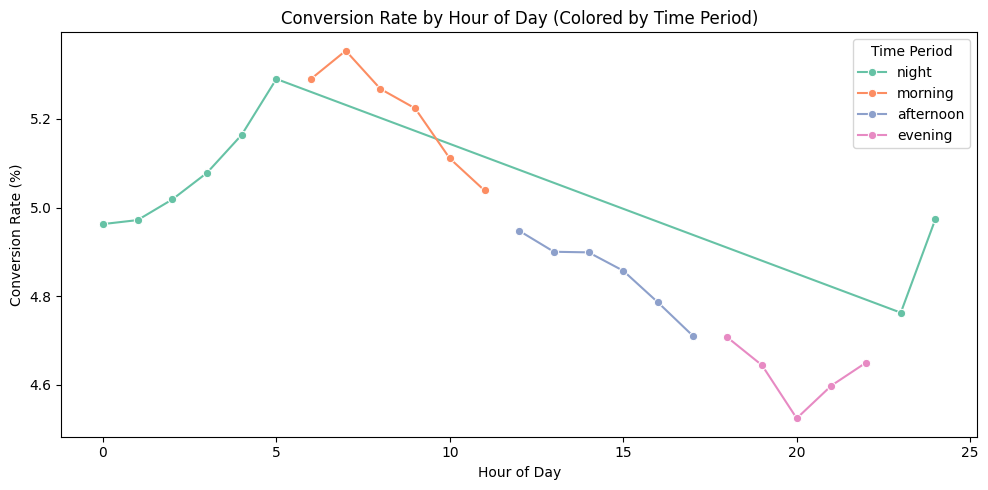

In [48]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    x='hour_of_day',
    y='cvr',
    data=hourly_performance,
    hue='time_period',
    palette='Set2',
    marker='o'
)
plt.title('Conversion Rate by Hour of Day (Colored by Time Period)')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate (%)')
plt.legend(title='Time Period')
plt.tight_layout()
plt.show()

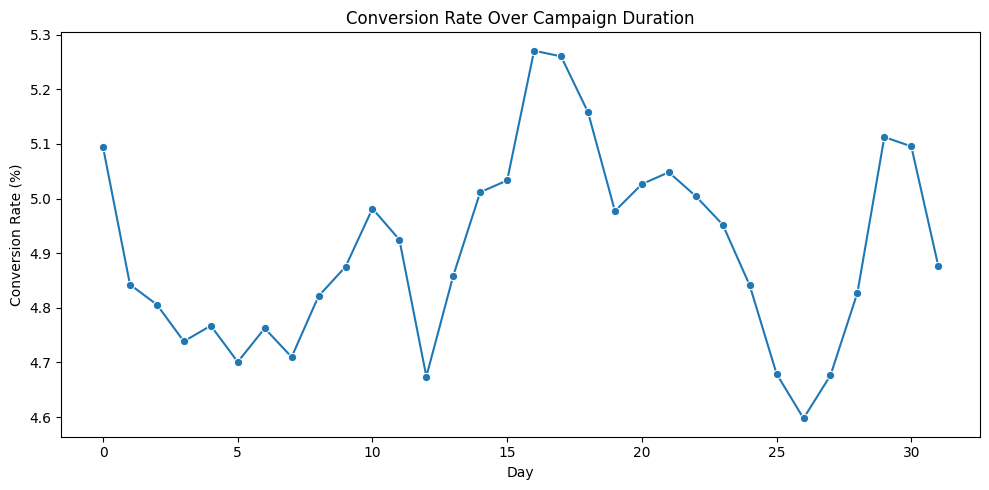

In [44]:
# Day-of-campaign progression
daily_performance = conn.execute(f"""
    SELECT 
        day_number,
        SUM(CAST(conversion AS INTEGER)) * 100.0 / COUNT(*) as cvr,
    FROM read_parquet('{silver_path}')
    GROUP BY day_number
    ORDER BY day_number
""").df()

plt.figure(figsize=(10, 5))
sns.lineplot(x='day_number', y='cvr', data=daily_performance, marker='o')
plt.title('Conversion Rate Over Campaign Duration')
plt.xlabel('Day')
plt.ylabel('Conversion Rate (%)')
plt.tight_layout()
plt.show()